**Problem 4.5**
**a)**
When coming up with our priors we like to assume ignorance. Using Jeffrey's prior makes sense because the rate of dissociation can also be represented by its reciprical. It is a rate constant and has no units. 

**b)** First we import our workhorses and load in our data set. 

In [19]:
import collections
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

%matplotlib inline

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Load data
df = pd.read_csv('./data/rasson_dissociation_anisotropy.csv', comment = '#')

First we need to clean up the data. We should split this data set into two because it is for two seperate trials. We can do this by pulling them out. But we want to create a new column for `[SDfluor](uM)` where the entire column is 0.005.

In [20]:
df.head()

,[SDfluor] (uM),[actin] (uM) trial 1,anisotropy trial 1,[actin] (uM) trial 2,anisotropy trial 2
0,0.005,31.10,115.2,16,126.3
1,NaN,16.55,114.0,8,128.4
2,NaN,8.28,113.9,4,126.4
3,NaN,4.14,112.7,2,122.4
4,NaN,2.07,109.0,1,119.7


In [23]:
df['[SDfluor] (uM)'] = 0.005

In [24]:
df

,[SDfluor] (uM),[actin] (uM) trial 1,anisotropy trial 1,[actin] (uM) trial 2,anisotropy trial 2
0,0.005,31.100,115.2,16.00,126.3
1,0.005,16.550,114.0,8.00,128.4
2,0.005,8.280,113.9,4.00,126.4
3,0.005,4.140,112.7,2.00,122.4
4,0.005,2.070,109.0,1.00,119.7
5,0.005,1.030,103.7,0.50,115.1
6,0.005,0.517,99.6,0.25,109.0
7,0.005,0.129,83.4,0.25,107.5
8,0.005,0.000,58.9,0.00,76.3


Now we can splice the data into two different `DataFrames`. 

In [71]:
# Seperate out trial 1
df1 = df[list(df.columns[:3])]

In [96]:
df1

,[SDfluor] (uM),[actin] (uM) trial 1,anisotropy trial 1
0,0.005,31.100,115.2
1,0.005,16.550,114.0
2,0.005,8.280,113.9
3,0.005,4.140,112.7
4,0.005,2.070,109.0
5,0.005,1.030,103.7
6,0.005,0.517,99.6
7,0.005,0.129,83.4
8,0.005,0.000,58.9


In [81]:
df2 = df[list(df.columns[:1]) + list(df.columns[3:5])]

In [107]:
df2

,[SDfluor] (uM),[actin] (uM) trial 2,anisotropy trial 2
0,0.005,16.00,126.3
1,0.005,8.00,128.4
2,0.005,4.00,126.4
3,0.005,2.00,122.4
4,0.005,1.00,119.7
5,0.005,0.50,115.1
6,0.005,0.25,109.0
7,0.005,0.25,107.5
8,0.005,0.00,76.3


Now we can come up wtih an equation to compute the $c_{ad}$. We can use the code given to us in the problem.

In [84]:
# Function to compute c_ad for dissociation reactions
def c_ad_dissoc(K_d_star, c_a_0, c_d_0):
    """
    Compute concentration of actin-S_D for a given value of c_a_0 and c_d_0.
    """
    poly_coeffs = np.array([1.0, 
                            -(K_d + c_a_0 + c_d_0), 
                            c_a_0 * c_d_0])
    
    # Use np.roots to solve for c_ad
    return np.roots(poly_coeffs).min()

We can compute the anisotrophy for $K_d^*$ using the code in the problem set. 

In [113]:
# Returns anisotropy from competition experiment.
def competition_anisotropy(K_d, K_d_star, c_a_0, c_d_0, c_d_star_0, r_f, r_b):
    """
    Returns anisotropy measured from competition experiment.
    """
    # Define coeffiencts for third order polynomial
    beta = K_d + K_d_star + c_d_0 + c_d_star_0 - c_a_0
    gamma = K_d * (c_d_star_0 - c_a_0) + K_d_star * (c_d_0 - c_a_0) \
                    + K_d * K_d_star
    delta = -K_d * K_d_star * c_a_0
    
    # Compute roots (one of them is concentration of free actin)
    poly_roots = np.roots(np.array([1.0, beta, gamma, delta]))

    # Get index of root that we want (real, between 0 and c_a_0)
    inds = (np.isreal(poly_roots)) & (0 < poly_roots) & (poly_roots < c_a_0)
    c_a = poly_roots[inds][0]

    # Compute c_d* and c_ad*
    c_ad_star = c_a * c_d_star_0 / (K_d_star + c_a)
    c_d_star = c_d_star_0 - c_ad_star
    
    # Compute anisotropy
    return (r_f * c_d_star + r_b * c_ad_star) / c_d_star_0

Now we can perform a regression for $K_d^*$.

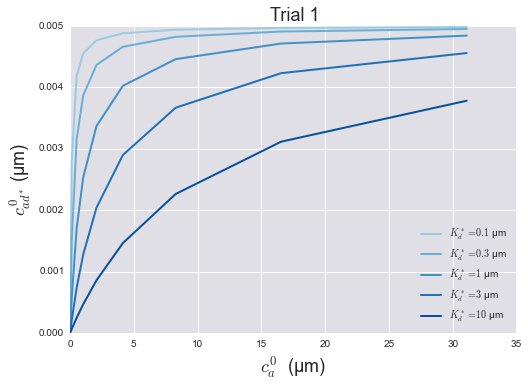

In [125]:
# Function to compute c_ad for dissociation reactions
def c_ad_dissoc(K_d, c_a_0, c_d_0):
    """
    Compute concentration of actin-S_D for a given value of c_a_0 and c_d_0.
    """
    poly_coeffs = np.array([1.0, -(K_d + c_a_0 + c_d_0), c_a_0 * c_d_0])
    
    # Use np.roots to solve for c_ad
    return np.roots(poly_coeffs).min()

# List of values we want to set for K_d
K_d = [0.1, 0.3, 1.0, 3.0, 10.0]

# The fixed SD concentration
c_d_0_star= 0.005

# grab the actin concentration from the data frame and make it into a list
c_a_0 = list(df1['[actin] (uM) trial 1'])

# Make plot
colors = sns.color_palette('Blues', 7)
for i in range(len(K_d_star)):
    # Compute c_ad_star over the values of c_a_0_star.
    c_ad_star = np.empty_like(c_a_0)
    for j in range(len(c_a_0)):
        c_ad_star[j] = c_ad_dissoc(K_d_star[i], c_a_0[j], c_d_0_star)

    # creat plot
    label = u'$K_d^* = %g$ µm' % K_d_star[i]
    plt.plot(c_a_0_star, c_ad_star, '-', color=colors[i+2], label=label)
    plt.xlabel(u'$c_a^0$ (µm)')
    plt.ylabel(u'$c_{ad^*}^0$ (µm)')
    plt.legend(loc='lower right')
    plt.title('Trial 1')

We can do this for our trail 2 data as well.

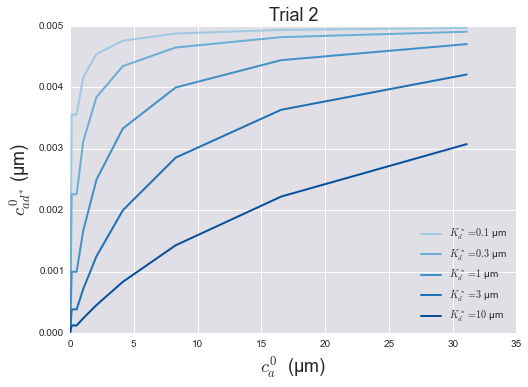

In [126]:
# Function to compute c_ad for dissociation reactions
def c_ad_dissoc(K_d, c_a_0, c_d_0):
    """
    Compute concentration of actin-S_D for a given value of c_a_0 and c_d_0.
    """
    poly_coeffs = np.array([1.0, -(K_d + c_a_0 + c_d_0), c_a_0 * c_d_0])
    
    # Use np.roots to solve for c_ad
    return np.roots(poly_coeffs).min()

# List of values we want to set for K_d
K_d = [0.1, 0.3, 1.0, 3.0, 10.0]

# The fixed SD concentration
c_d_0_star= 0.005

# grab the actin concentration for the data fram and make it into a list
c_a_0 = list(df2['[actin] (uM) trial 2'])

# Make plot
colors = sns.color_palette('Blues', 7)
for i in range(len(K_d_star)):
    # Compute c_ad_star over the values of c_a_0_star.
    c_ad_star = np.empty_like(c_a_0)
    for j in range(len(c_a_0)):
        c_ad_star[j] = c_ad_dissoc(K_d_star[i], c_a_0[j], c_d_0_star)

    # plot it
    label = u'$K_d^* = %g$ µm' % K_d_star[i]
    plt.plot(c_a_0_star, c_ad_star, '-', color=colors[i+2], label=label)
    plt.xlabel(u'$c_a^0$ (µm)')
    plt.ylabel(u'$c_{ad^*}^0$ (µm)')
    plt.legend(loc='lower right')
    plt.title('Trial 2')